# Crossentropy method

This notebook will teach you to solve reinforcement learning problems with crossentropy method. We'll follow-up by scaling everything up and using neural network policy.

In [1]:
#!pip install wheel==0.38.4
#!pip install setuptools==66
#!pip install gym==0.21.0

import os

In [2]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


# Initialize policy (0.5pts)

In [4]:
policy = np.ones((n_states, n_actions))/n_actions
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
print("Ok!")

Ok!


# Play the game (0.5pts)

Just like before, but we also record all states and actions we took.

In [5]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        a = np.random.choice(range(n_actions), p = policy[s])
        
        new_s,r,done,info = env.step(a)
        
        #Record state, action and add up reward to states,actions and total_reward accordingly. 
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done:
            break
    return states,actions,total_reward
        

In [7]:
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]

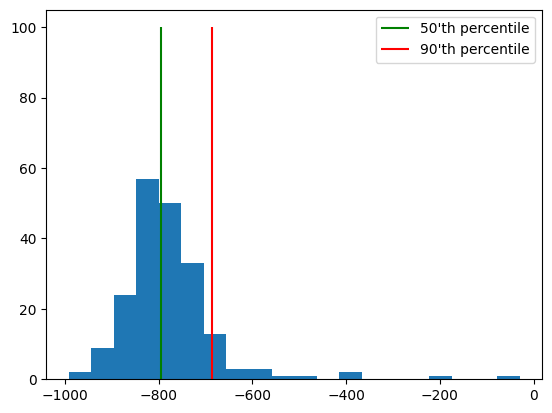

In [8]:
#let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(policy,t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards,bins=20);
plt.vlines([np.percentile(sample_rewards,50)],[0],[100],label="50'th percentile",color='green')
plt.vlines([np.percentile(sample_rewards,90)],[0],[100],label="90'th percentile",color='red')
plt.legend()

### Crossentropy method steps (1pts)

In [9]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states = [s for i in range(len(states_batch)) if rewards_batch[i]>=reward_threshold for s in states_batch[i]]
    elite_actions = [a for i in range(len(actions_batch)) if rewards_batch[i]>=reward_threshold for a in actions_batch[i]]
    
    '''if(len(np.array(states_batch[0]).shape) == 1):
        elite_states = np.hstack(#states)
    else:
        elite_states = np.vstack(#states)
    elite_actions = np.hstack(#actions)'''
    
    return elite_states,elite_actions
    

In [17]:
states_batch = [
    [1,2,3],   #game1
    [4,2,0,2], #game2
    [3,1]      #game3
]

actions_batch = [
    [0,2,4],   #game1
    [3,2,0,1], #game2
    [3,3]      #game3
]
rewards_batch = np.array([
    3,         #game1
    4,         #game2
    5,         #game3
])

test_result_0 = select_elites(states_batch,actions_batch,rewards_batch,percentile=0)
test_result_40 = select_elites(states_batch,actions_batch,rewards_batch,percentile=30)
test_result_90 = select_elites(states_batch,actions_batch,rewards_batch,percentile=90)
test_result_100 = select_elites(states_batch,actions_batch,rewards_batch,percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
   and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
        "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_40[0] == [4, 2, 0, 2, 3, 1]) and \
        np.all(test_result_40[1] ==[3, 2, 0, 1, 3, 3]),\
        "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3,1]) and \
        np.all(test_result_90[1] == [3,3]),\
        "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3,1]) and\
       np.all(test_result_100[1] == [3,3]),\
        "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [19]:
from collections import defaultdict
def update_policy(elite_states,elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to
    
    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]
    
    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions
    
    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions
    
    """
    
    new_policy = np.zeros([n_states,n_actions])
    
    #<Your code here: update probabilities for actions given elite states & actions>
    #Don't forget to set 1/n_actions for all actions in unvisited states.
    state_action_dict = defaultdict(lambda: [0]*n_actions)
    for i in range(len(elite_states)):
        state_action_dict[elite_states[i]][elite_actions[i]]+=1
    for i in range(n_states):
        if i not in state_action_dict:
            new_policy[i] = [1 / n_actions] * n_actions
        else:
            new_policy[i] = [p / sum(state_action_dict[i]) for p in state_action_dict[i]]
    

    return new_policy

In [20]:

elite_states, elite_actions = ([1, 2, 3, 4, 2, 0, 2, 3, 1], [0, 2, 4, 3, 2, 0, 1, 3, 3])


new_policy = update_policy(elite_states,elite_actions)

assert np.isfinite(new_policy).all(), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy>=0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1),1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5       ,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333,  0.66666667,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.5       ,  0.5       ]])
print(new_policy[:4,:5])
assert np.allclose(new_policy[:4,:5],reference_answer)
print("Ok!")

[[1.         0.         0.         0.         0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.33333333 0.66666667 0.         0.        ]
 [0.         0.         0.         0.5        0.5       ]]
Ok!


# Training loop (1pts)
Generate sessions, select N best and fit to those.

In [21]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def show_progress(rewards_batch,log, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [22]:
#reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions 

mean reward = -48.560, threshold=8.000


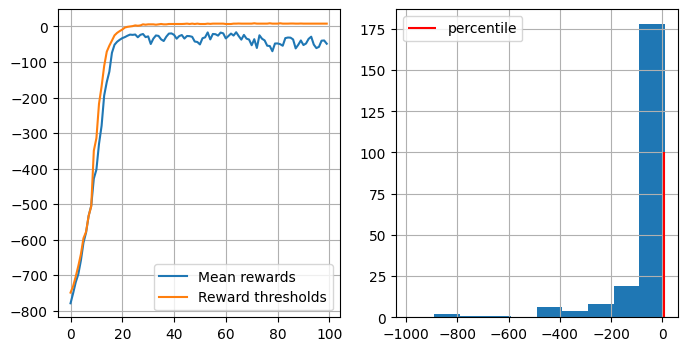

In [24]:
n_sessions = 250  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []

for i in range(100):
    
    %time sessions = [generate_session(policy) for _ in range(n_sessions)]
    
    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile=50)
    
    new_policy = update_policy(elite_states,elite_actions)
    
    policy = learning_rate * new_policy + (1 - learning_rate) * policy #update policy
    
    #display results on chart
    show_progress(rewards_batch,log)

# Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (1 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples. Show all precentiles on one graph and all n_samples on another
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


In [26]:
import gym
import numpy as np, pandas as pd

env = gym.make("Taxi-v3")
env.reset()
n_states = env.observation_space.n
n_actions = env.action_space.n
policy = 1/6. * np.ones([n_states, n_actions])
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)
s,a,r = generate_session(policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float,np.float64]
policy = np.ones([n_states,n_actions])/n_actions 
stepCounter = 40

# How do different percentiles affect training efficiency?

In [29]:
n_sessions = 250  #sample this many sessions
percentiles = [i for i in range(0, 0 + 250 * 10, 10)]  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []
mean = []
for percentile in percentiles:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch,percentile=percentile)

        new_policy = update_policy(elite_states,elite_actions) #set new policy
        policy = learning_rate * new_policy + (1 - learning_rate) * policy #update policy
        curMean[i] = (policy + new_policy) / 2 #add mean value
        clear_output(True)
    mean.append(curMean)
    #display results on chart
    #show_progress(rewards_batch,log)

CPU times: total: 1.02 s
Wall time: 1.52 s


IndexError: list assignment index out of range

In [ ]:
# How do different percentiles affect training efficiency?

Make a graph with several training runs with different hyperparemeters

In [ ]:
n_sessions_ar = []  #sample this many sessions
perc = 70  #take this percent of session with highest rewards
learning_rate = 0.5  #add this thing to all counts for stability

log = []
mean = []
for n_sessions in n_sessions_ar:
    curMean = []
    policy = np.ones([n_states,n_actions])/n_actions
    for i in range(stepCounter):

        %time sessions = [generate_session(policy) for _ in range(n_sessions)]

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(np.array(states_batch),
                                                    np.array(actions_batch),np.array(rewards_batch),percentile=perc)

        #set new policy
        #update policy
        #add mean value
        clear_output(True)
    mean.append(curMean)
    #display results on chart
    #show_progress(rewards_batch,log)

# Stabilize positive rewards by averaging policy across 10 games (4 pts)

In [ ]:
def generate_session(policy,t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    #code here
    return states,actions,total_reward
        

In [ ]:
n_sessions = 75  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate = 0.2  #add this thing to all counts for stability

log = []
mean = []
policy = np.ones([n_states,n_actions])/n_actions
for i in range(1000):

    %time sessions = [generate_session(policy) for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(np.array(states_batch),np.array(actions_batch),np.array(rewards_batch),percentile=50)

    #code here

    show_progress(rewards_batch,log)
    
    if(np.mean(rewards_batch) > 7):
        print("win!")
        break